In [1]:
import torch
from torch import nn
import torch.optim as optim
import pygame
import json 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

d:\Code\University\Code_LMU\GAN-BERT-Classifier\py39env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.5.0 (SDL 2.28.0, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# SCREEN_WIDTH    = 100
# SCREEN_HEIGHT   = 20
# FONT_SIZE       = 10 

SEED = 0    # TODO: define seed of python, numpy, torch

SCREEN_WIDTH    = 130
SCREEN_HEIGHT   = 25
FONT_SIZE       = 15 
# 4680
FONT_PATH           = "../converttext/noto-sans.regular.ttf"
PATH_WORD_NUM_DICT  = 'word_num_dict.json'
PATH_WORD_TO_ID     = 'word_to_id_dict.json'
PATH_ID_TO_WORD     = 'id_to_word_dict.json'

DEVICE_NAME         = "cuda:0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MODEL_OUT_CHANNELS  = 16
MODEL_KERNEL_SIZE   = 3
MODEL_SITRIDE       = 1
MODEL_PADDING       = 1
MODEL_LINEAR_SIZE   = 12480
OPTIM_LEARNING_RATE = 0.001

TRAIN_BATCH_SIZE    = 16
DEV_BATCH_SIZE      = 16
TRAIN_NUM_EPOCHS    = 10

PATH_FOLDER_NAME = f"CNN_"
os.mkdir(PATH_FOLDER_NAME)

PATH_CONFIG = "./{PATH_FOLDER_NAME}/config.json"    # TODO: save config in json
PATH_TRAIN_LOSS_PLOT = f"./{PATH_FOLDER_NAME}/train_loss.jpg"
PATH_DEV_ACC_PLOT    = f"./{PATH_FOLDER_NAME}/dev_loss.jpg"
PATH_DEV_CONF_PLOT   = f"./{PATH_FOLDER_NAME}/dev_loss.jpg"

PATH_DATA   = f"./{PATH_FOLDER_NAME}/train_data.csv"    # TODO: save data in csv
PATH_MODEL  = f"./{PATH_FOLDER_NAME}/CNN.pth"

In [3]:
class CNN(nn.Module):
    def __init__(self, out_channels=6, kernel_size=1, stride=1, padding=0, vocab_size=5000, linear_size=5000, normalization=False):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(linear_size, vocab_size) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [4]:
pygame.init()
font_noto_sans_regular = pygame.font.Font(FONT_PATH, FONT_SIZE)


def to_image(text:str, font, id:int=None, noise=False):
  # pygame.init()
  # screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
  screen = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
  screen.fill((255, 255, 255))
  # draw image
  img = font.render(str(text), True, (0, 0, 0))
  screen.blit(img, (2, 0))
  for event in pygame.event.get():
    if event.type == pygame.QUIT:
      run = False
  # pygame.display.flip() 
  # Save the screen as an image when the program finishes
  if noise == False:
    # TODO: obtain font name
    filename = f"./temp_image/word_{str(id)}_{str(text)}_notoSans.png"
  else:
    filename = f"./temp_image/word_{str(id)}_{str(text)}_notoSans_noised.png"
  pygame.image.save(screen, filename)
  # print("Screen saved as ", filename)
  # pygame.quit()
  return filename

image_path = to_image(text="1nd1st1nguishαble", font=font_noto_sans_regular, id=5, noise=False)


In [5]:
# load dictionary

with open(PATH_WORD_NUM_DICT, 'r') as fp:
    word_num_dict_test = json.load(fp)
with open(PATH_WORD_TO_ID, 'r') as fp:
    word_to_id_dict_test = json.load(fp)
with open(PATH_ID_TO_WORD, 'r') as fp:
    id_to_word_dict_test = json.load(fp)
    
print("test load: length of word_num_dict:", len(word_num_dict_test.keys()))
print("test load: length of word_to_id_dict_test:", len(word_to_id_dict_test.keys()))
print("test load: length of id_to_word_dict_test:", len(id_to_word_dict_test.keys()))
print('note index needs to use str(index)')
print(f"test load: index: [5], word in id_to_word_dict: [{id_to_word_dict_test[str(5)]}], id in word_id_dict: [{word_to_id_dict_test[id_to_word_dict_test['5']]}]")

VOCAB_SIZE = len(word_num_dict_test.keys())


test load: length of word_num_dict: 4572
test load: length of word_to_id_dict_test: 4572
test load: length of id_to_word_dict_test: 4572
note index needs to use str(index)
test load: index: [5], word in id_to_word_dict: [defines], id in word_id_dict: [5]


In [6]:
# define dataset

transform_norm = transforms.Compose([
    transforms.ToTensor(),
])
class WordImageIDDataset(Dataset):
    def __init__(self, word_to_id_list, font, noise=False):
        self.word_to_id_list = word_to_id_list
        self.font = font
        self.noise = noise
    
    def __len__(self):
        return len(self.word_to_id_list)
    
    def __getitem__(self, index):
        ''' index is not token ID '''
        output_word = self.word_to_id_list[index][0]
        image_path = to_image(
            text=output_word, 
            font=self.font,
            id=index, 
            noise=self.noise)
        
        # for path in image_paths:
        output_img = Image.open(image_path).convert('L')
        output_img = transform_norm(output_img)
        id = self.word_to_id_list[index][1]
        # output_id_onehot = torch.zeros(1, VOCAB_SIZE)
        # output_id_onehot[0][id] = 1
        output_id_onehot = torch.zeros(VOCAB_SIZE)
        output_id_onehot[id] = 1
                
        output = {'word'    : output_word,
                  'image'   : output_img,
                  'id'      : output_id_onehot}
        return output

In [7]:
model = CNN(out_channels=MODEL_OUT_CHANNELS, 
            kernel_size=MODEL_KERNEL_SIZE, 
            stride=MODEL_SITRIDE, 
            padding=MODEL_PADDING, vocab_size=VOCAB_SIZE, normalization=False, linear_size=MODEL_LINEAR_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=OPTIM_LEARNING_RATE)
dataset = WordImageIDDataset(word_to_id_list = list(word_to_id_dict_test.items()),
                            font=font_noto_sans_regular,
                            noise=False)
dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

epoch: 1
9.748070723526961
epoch: 2
8.02033131939548
epoch: 3
5.5100287857589185
epoch: 4
1.534963417615924
epoch: 5
0.48578434599029435
epoch: 6
0.24576857092080417
epoch: 7
0.14954587660560553
epoch: 8
0.0928432532338673
epoch: 9
0.06852885646830228
epoch: 10
0.050436224540943035


ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

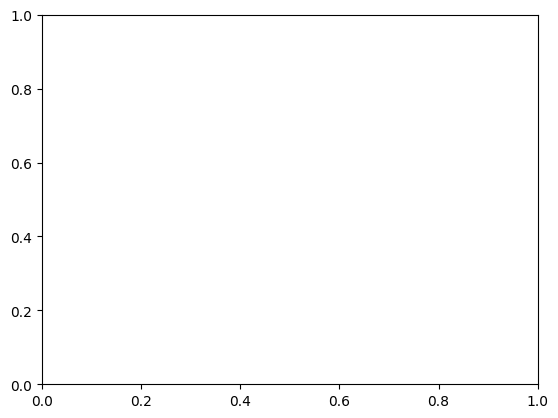

In [8]:
train_loss = []
for epoch in range(1, TRAIN_NUM_EPOCHS + 1):
    print(f'epoch: {epoch}')
    epoch_loss = []
    for data in dataloader:
        words    = data['word']
        imgs     = data['image']
        ids      = data['id']
        optimizer.zero_grad()
        # print(word)
        # print(imgs.shape)
        # print(id)
        # print(ids.shape)
        # read image    
        outputs = model(imgs.to(device))
        # print(output)
        # softmax = torch.nn.Softmax()
        # outputs = softmax(outputs)
        # print(pred) 
        # print(preds.shape)
        # print(ids.shape)
        
        loss = criterion(outputs, ids.to(device))
        # print("Loss:", loss.item())
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        # torch.cuda.empty_cache()
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print(epoch_average_loss)
    train_loss.append(epoch_average_loss)

x = range(1, TRAIN_NUM_EPOCHS+1)
plt.plot(x, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.savefig(PATH_TRAIN_LOSS_PLOT)
plt.show()

# TODO: save data as csv
# TODO: validation (dev)


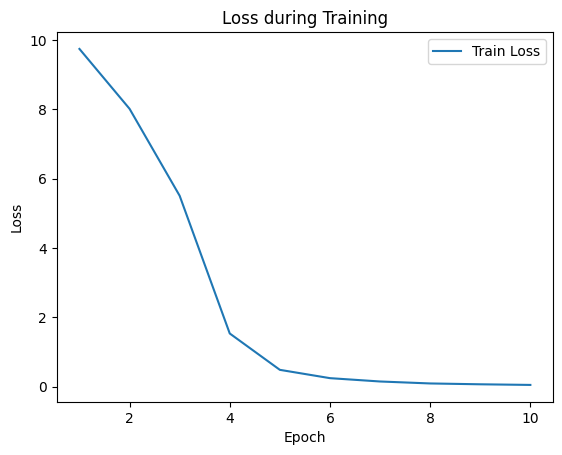

In [10]:
x = range(1, TRAIN_NUM_EPOCHS+1)
plt.plot(x, train_loss, label="Train Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()
plt.savefig(PATH_TRAIN_LOSS_PLOT)
plt.show()


In [ ]:
torch.save(model, PATH_MODEL)